In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from custom.watermarks import add_watermark

from datetime import datetime
last_update = datetime.today().strftime("%d-%m-%Y %H:%M")

## Importa i dati

### vaccini

In [2]:
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"  
df_vacc = pd.read_csv(url)
df_vacc = df_vacc.fillna(method="ffill")

def get_vaccine_data(country, time_window=30, t0=-1, fully=True, last_day=False):
    """ Recupera dati sulla frazione di vaccinati medi negli ultimi 30 giorni"""

    df_vacc_country = df_vacc[df_vacc["location"] == country].iloc[2:, :]

    if fully==True:
        vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"])
    else:
        vacc_fully = np.array(df_vacc_country["total_vaccinated_per_hundred"])

    if last_day==False:  
        vacc_ultimi_Ngiorni = np.mean(vacc_fully[t0-(time_window+1) : t0])
    elif last_day==True:
        vacc_ultimi_Ngiorni = vacc_fully[-1]

    return vacc_ultimi_Ngiorni

### epidemia

In [3]:
file_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"  
df_deaths = pd.read_csv(file_deaths)

def get_deaths(country, time_window=30, t0=-1):
    decessi = np.array(df_deaths[df_deaths['Country/Region']==country].iloc[:, 4:].sum())
    decessi_ultimi_Ngiorni = decessi[t0] - decessi[t0-(time_window+1)]
    return decessi_ultimi_Ngiorni

### demografici

In [4]:
paesi = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Croatia', 
         'Denmark', 'Estonia', 'Finland', 'France', 
         'Germany', 'Greece', 'Ireland', 'Italy', 'Latvia', 
         'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
         'Poland', 'Portugal', 'Czechia', 'Romania',
         'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Hungary']

abitanti = {'Austria':8.917, 'Belgium':11.56, 'Bulgaria':6.927, 'Cyprus':1.207, 'Croatia':4.047, 
            'Denmark':5.831, 'Estonia':1.331, 'Finland':5.531, 'France':67.39, 
            'Germany':83.24, 'Greece':10.27, 'Ireland':4.995, 'Italy':59.55, 'Latvia':1.902, 
            'Lithuania':2.795, 'Luxembourg':0.632275, 'Malta':0.525285, 'Netherlands':17.44, 
            'Poland':37.95, 'Portugal':10.31, 'Czechia':10.7, 'Romania':19.29,
            'Slovakia':5.549, 'Slovenia':2.1, 'Spain':47.35, 'Sweden':10.35, 'Hungary':9.75}

## Calcola la correlazione

In [5]:
plt.style.use('seaborn-dark')

In [6]:
dec_res_2021=[]
vacc_res_2021=[]

tw = 210
t0 = -1

for p in paesi:
    vacc_res_2021.append(get_vaccine_data(p, fully=True, last_day=True))
    dec_res_2021.append(get_deaths(p, time_window = tw, t0=t0)/abitanti[p])

dec_res_2021 = np.array(dec_res_2021)

corr_coeff = round(np.corrcoef(vacc_res_2021, dec_res_2021)[0, 1], 2)
print(corr_coeff)

-0.83


In [7]:
# fit lineare
coeff_fit = np.polyfit(vacc_res_2021, dec_res_2021, 1)
x_grid = np.arange(0, 100, 1)

def linear_model(x):
    y = coeff_fit[1] + coeff_fit[0]*x
    return y

y_grid = [linear_model(v) for v in x_grid]

watermark fontsize: 29, angle:-28.07


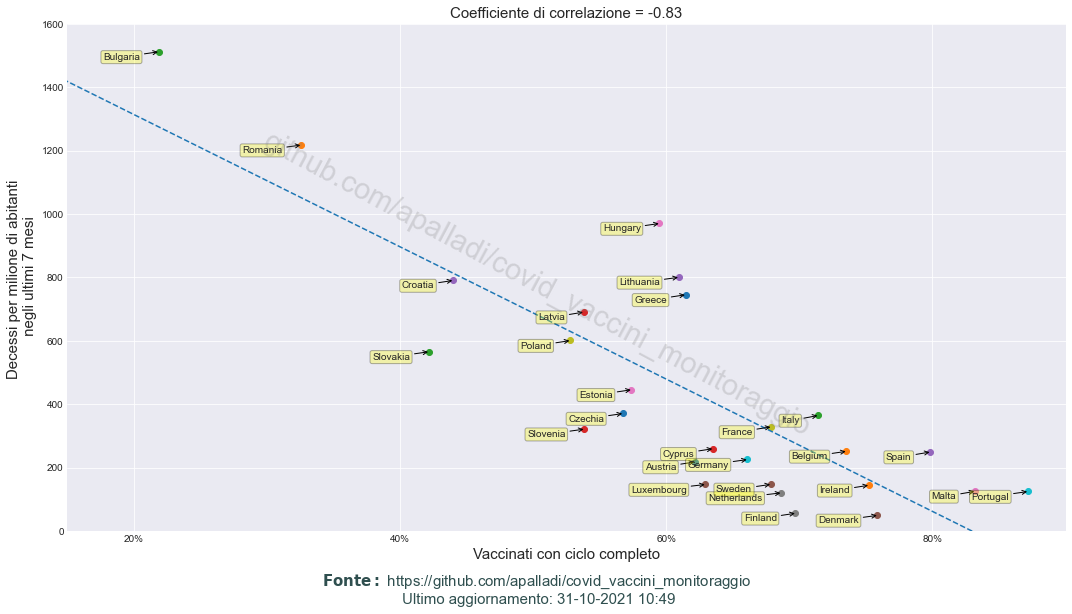

In [8]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(vacc_res_2021)):
    plt.scatter(vacc_res_2021[i], dec_res_2021[i])
    plt.annotate(paesi[i], 
               xy=(vacc_res_2021[i]+0.1, dec_res_2021[i]),
               xytext = (-20, -10), 
               textcoords='offset points', ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
               arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.plot(x_grid, y_grid, linestyle='--')
plt.xticks(np.arange(0, 101, 20), ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.ylim(0, 1600)
plt.xlim(15, 90)
plt.title('Coefficiente di correlazione = '+str(corr_coeff), fontsize=15)
plt.xlabel('Vaccinati con ciclo completo', fontsize=15)
plt.ylabel('Decessi per milione di abitanti \n negli ultimi 7 mesi', fontsize=15)
plt.grid()
# Add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig("../risultati/vaccini_decessi_EU.png",
                dpi=300,
                bbox_inches="tight")
plt.show()

### correlazione in funzione del tempo

In [9]:
def corr_window(tw):

    dec_res=[]
    vacc_res=[]

    for p in paesi:
        vacc_res.append(get_vaccine_data(p, fully=True, last_day=True))
        dec_res.append(get_deaths(p, time_window = tw)/abitanti[p])

    corr_tw = np.corrcoef(vacc_res, dec_res)[0, 1]

    return corr_tw

tw_grid = np.arange(7, 300, 5)
corr_grid = [np.abs(corr_window(tw)) for tw in tw_grid]

ideal_window = tw_grid[np.argmax(corr_grid)]
print(ideal_window)

212


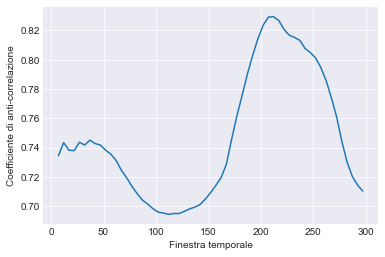

In [10]:
plt.plot(tw_grid, corr_grid)
plt.xlabel('Finestra temporale')
plt.ylabel('Coefficiente di anti-correlazione')
plt.grid()
plt.show()